<a href="https://colab.research.google.com/github/cuauwalker/Investments/blob/master/secuencial_red_base_capas_densas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fuente original

https://www.tensorflow.org/datasets/keras_example

Nota: algunas partes del notebook se han modificado para simplifar los ejemplos


Copyright 2020 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

### Load a dataset

Load the MNIST dataset with the following arguments:

* `shuffle_files=True`: The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
* `as_supervised=True`: Returns a tuple `(img, label)` instead of a dictionary `{'image': img, 'label': label}`.

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


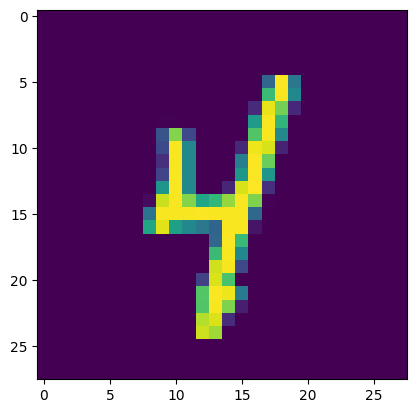

In [ ]:
sample, label = next(iter(ds_train.take(1)))
plt.imshow(sample)

### Build a training pipeline

Apply the following transformations:

* `tf.data.Dataset.map`: TFDS provide images of type `tf.uint8`, while the model expects `tf.float32`. Therefore, you need to normalize images.
* `tf.data.Dataset.cache` As you fit the dataset in memory, cache it before shuffling for a better performance.<br/>
__Note:__ Random transformations should be applied after caching.
* `tf.data.Dataset.shuffle`: For true randomness, set the shuffle buffer to the full dataset size.<br/>
__Note:__ For large datasets that can't fit in memory, use `buffer_size=1000` if your system allows it.
* `tf.data.Dataset.batch`: Batch elements of the dataset after shuffling to get unique batches at each epoch.
* `tf.data.Dataset.prefetch`: It is good practice to end the pipeline by prefetching [for performance](https://www.tensorflow.org/guide/data_performance#prefetching).

In [ ]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

### Build an evaluation pipeline

Your testing pipeline is similar to the training pipeline with small differences:

 * You don't need to call `tf.data.Dataset.shuffle`.
 * Caching is done after batching because batches can be the same between epochs.

In [ ]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Step 2: Create and train the model

Plug the TFDS input pipeline into a simple Keras model, compile the model, and train it.

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.6035 - sparse_categorical_accuracy: 0.8363 - val_loss: 0.1908 - val_sparse_categorical_accuracy: 0.9447
Epoch 2/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1807 - sparse_categorical_accuracy: 0.9491 - val_loss: 0.1380 - val_sparse_categorical_accuracy: 0.9596
Epoch 3/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.9647 - val_loss: 0.1093 - val_sparse_categorical_accuracy: 0.9673
Epoch 4/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0962 - sparse_categorical_accuracy: 0.9719 - val_loss: 0.0957 - val_sparse_categorical_accuracy: 0.9703
Epoch 5/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0754 - sparse_categorical_accuracy: 0.9786 - val_loss: 0.0890 - val_sparse_categorical_accuracy: 0.9730
Epoch 6/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0625 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.0818 - val_sparse_categorical_accuracy: 0.9759


tf.Tensor(2, shape=(), dtype=int64)


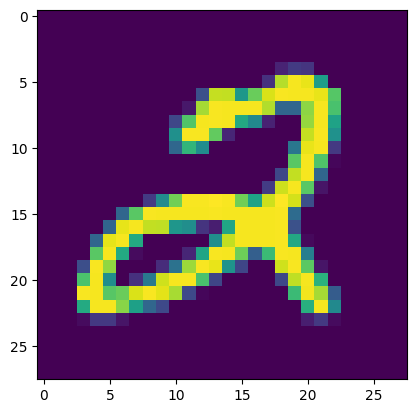

In [ ]:
sample, label = next(iter(ds_test.take(1)))
print(label[0])
plt.imshow(sample[0])

In [ ]:
model.evaluate(ds_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0824 - sparse_categorical_accuracy: 0.9738


[0.08181066811084747, 0.9758999943733215]